# Class \#15 activities

# **Detecting sea level rise from Florida tide gauge records**
### Practice with Pandas time series analysis

<img src="https://drive.google.com/uc?export=view&id=1hSIOjtYu1jHM1sfi32KjCSwxi1ADybyR" width="1200" />

**Data description:** Two netCDF files with hourly tide gauge records from Key West, FL (from 1913 to present) and Pensacola, FL (from 1923 to present). The tide gauge measurements are of relative sea level (RSL), which includes both sea level rise (from ice melt and thermal expansion) and local vertical land motion (from subsidence and isostatic rebound).

**Data source:** [University of Hawaii Sea Level Center](https://uhslc.soest.hawaii.edu/datainfo/)

1. Uncomment the blocks of code with the installation lines (`!pip install`, etc.). Remember the shortcut to uncomment/comment multiple lines is `Command-/` on Macs or `Control-/` on Windows.

2. Then run this cell to install the packages, import libraries, and give Colab access to Google Drive.

3. When prompted, click the link to give Colab access to Google Drive, copy the code, and paste back into here.

In [3]:
# # This code installs the netCDF4 module
# # Run this code once per session, then comment it out
# !pip install netcdf4

# # This code allows Cartopy to work with Google Colab
# # Run this code once per session, then comment it out
# !grep '^deb ' /etc/apt/sources.list | \
#   sed 's/^deb /deb-src /g' | \
#   tee /etc/apt/sources.list.d/deb-src.list
# !apt-get -qq update
# !apt-get -qq build-dep python3-cartopy
# !pip uninstall -y shapely
# !pip install shapely --no-binary shapely
# !pip install cartopy

# Import NumPy, xarray, Matplotlib, Cartopy (and related imports)
import numpy as np
import pandas as pd
from scipy import interpolate, stats
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# Give Colab access to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


4. Next, update the filepath below. To find the correct filepath, you can click on the left sidebar (folder icon), navigate to the Class #15 data folder, click the "..." on the file, and select "Copy path."

5. Add back slashes (`\`) in front of quotation marks in the filepath, as necessary.

In [4]:
# Folder for tide gauge records
folder = '/content/drive/MyDrive/OCEAN 215 - Autumn \'20/OCEAN 215 - Autumn \'20 - Course documents/Zoom class slides and notebooks/2020-11-24 - class #15 - data/'

6. Run the code cell below to load and process the netCDF files using `xarray`, then convert them to Pandas Series format.

In [5]:
# Load netCDF files using xarray
key_west_xr = xr.open_dataset(folder + 'tide_gauge_key_west_fl.nc')
key_west_xr = key_west_xr.drop('record_id').squeeze()
pensacola_xr = xr.open_dataset(folder + 'tide_gauge_pensacola_fl.nc')
pensacola_xr = pensacola_xr.drop('record_id').squeeze()

# Display file
display(key_west_xr)

# Convert each sea level record to Pandas Series
key_west = key_west_xr['sea_level'].to_pandas()
key_west.name = 'sea_level'
pensacola = pensacola_xr['sea_level'].to_pandas()
pensacola.name = 'sea_level'

# Display new Pandas series
display(pensacola)

<xarray.Dataset>
Dimensions:               (time: 944082)
Coordinates:
  * time                  (time) datetime64[ns] 1913-01-19T06:00:00 ... 2020-09-30T22:59:59.971200
Data variables:
    sea_level             (time) float32 ...
    lat                   float32 ...
    lon                   float32 ...
    station_name          |S12 ...
    station_country       |S30 ...
    station_country_code  float32 ...
    uhslc_id              int16 ...
    gloss_id              float32 ...
    ssc_id                |S4 ...
    last_rq_date          datetime64[ns] ...
Attributes:
    title:                  UHSLC Fast Delivery Tide Gauge Data (hourly)
    ncei_template_version:  NCEI_NetCDF_TimeSeries_Orthogonal_Template_v2.0
    featureType:            timeSeries
    Conventions:            CF-1.6, ACDD-1.3
    date_created:           2020-11-24T14:42:15Z
    publisher_name:         University of Hawaii Sea Level Center (UHSLC)
    publisher_email:        philiprt@hawaii.edu, markm@soest.hawaii.edu
    publisher_url:          http://uhslc.soest.hawaii.edu
    summary:                The UHSLC assembles and distributes the Fast Deli...
    processing_level:       Fast Delivery (FD) data undergo a level 1 quality...
    acknowledgment:         The UHSLC Fast Delivery database is supported by ...

time
1923-05-01 06:00:00.000000    2530.0
1923-05-01 07:00:00.028800    2560.0
1923-05-01 07:59:59.971200    2591.0
1923-05-01 09:00:00.000000    2621.0
1923-05-01 10:00:00.028800    2652.0
                               ...  
2020-09-30 19:00:00.028800    3082.0
2020-09-30 19:59:59.971200    3045.0
2020-09-30 21:00:00.000000    3007.0
2020-09-30 22:00:00.028800    2978.0
2020-09-30 22:59:59.971200    2957.0
Name: sea_level, Length: 853986, dtype: float32

7. Plot the time series from Key West and Pensacola.


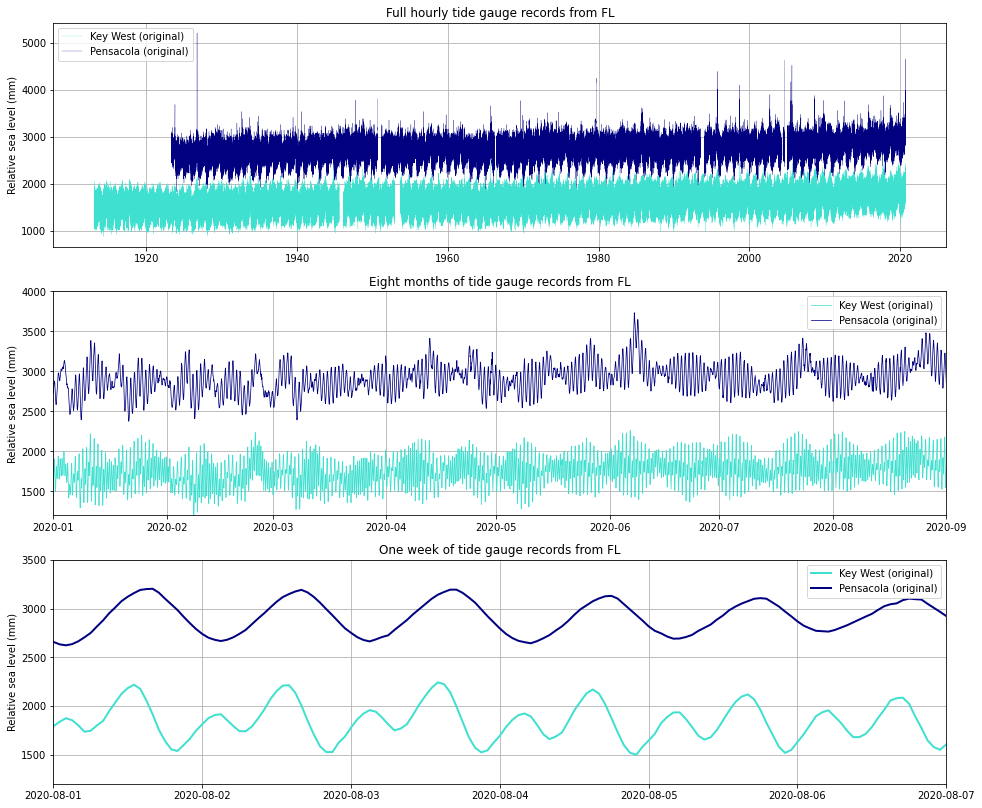

In [6]:
fig, (ax0,ax1,ax2) = plt.subplots(ncols=1,nrows=3,figsize=(16,14))
ax0.plot(key_west.index.values,key_west.values,lw=0.25,c='turquoise',label='Key West (original)')
ax0.plot(pensacola.index.values,pensacola.values,lw=0.25,c='navy',label='Pensacola (original)')
ax0.grid()
ax0.legend()
ax0.set_ylabel('Relative sea level (mm)')
ax0.set_title('Full hourly tide gauge records from FL')

ax1.plot(key_west.index.values,key_west.values,lw=0.75,c='turquoise',label='Key West (original)')
ax1.plot(pensacola.index.values,pensacola.values,lw=0.75,c='navy',label='Pensacola (original)')
ax1.grid()
ax1.legend()
ax1.set_ylabel('Relative sea level (mm)')
ax1.set_title('Eight months of tide gauge records from FL')
ax1.set_xlim([datetime(2020,1,1),datetime(2020,9,1)])
ax1.set_ylim([1200,4000])

ax2.plot(key_west.index.values,key_west.values,lw=2,c='turquoise',label='Key West (original)')
ax2.plot(pensacola.index.values,pensacola.values,lw=2,c='navy',label='Pensacola (original)')
ax2.grid()
ax2.legend()
ax2.set_ylabel('Relative sea level (mm)')
ax2.set_title('One week of tide gauge records from FL')
ax2.set_xlim([datetime(2020,8,1),datetime(2020,8,7)])
ax2.set_ylim([1200,3500]);

# **Breakout rooms: group 1 — daily averages using `.resample()`**


First, assign roles:
> * **Timekeeper:** keep things moving
>
> * **Coder:** share your screen and write the code based on input from everyone else
>
> * **Reporter:** before the end of the session, remind the Coder to paste their code into this [Google Document](https://docs.google.com/document/d/1HkbODx5MycvYKL06bCDYFf6DMmbDBP19m4MNjke5paM/edit?usp=sharing)

If you need help, check out the Lesson #15 Colab notebook, [available here](https://colab.research.google.com/drive/1z6vYlfFZbidD7RBv4VwAzstBwQFZ6bAw?usp=sharing).

The r^2 value is: 0.22689327917643126
This means that ~22% of the variance in one location can be explained by the other location's record.



time
1913-01-19    1436.166626
1913-01-20    1435.166626
1913-01-21    1425.041626
1913-01-22    1433.833374
1913-01-23    1479.541626
                 ...     
2020-09-26    2065.333252
2020-09-27    2043.208374
2020-09-28    2031.375000
2020-09-29    2027.541626
2020-09-30    2036.166626
Freq: D, Name: sea_level, Length: 39337, dtype: float32


The r^2 value is: 0.5295360185317727
This means that ~53% of the daily-average variance in one location can be explained by the other location's record.


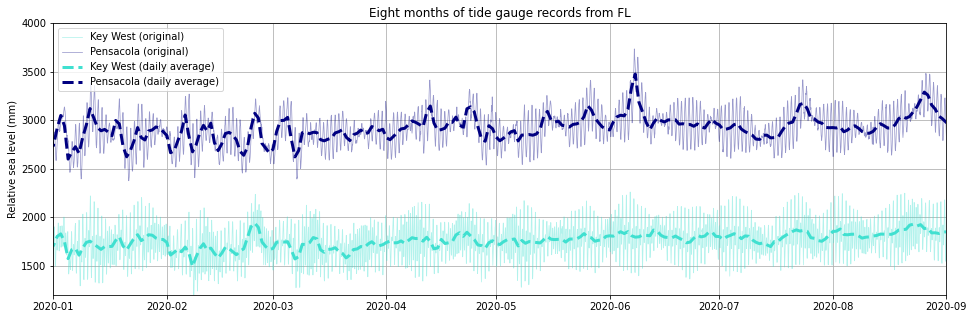

In [7]:
# 1a. Correlate the two Pandas Series, "key_west" and "pensacola", using the .corr() function.
# 1b. From this, calculate and print r^2.
# 1c. How much of the hourly variance in Key West sea level can be explained by sea level in Pensacola?
r = key_west.corr(pensacola)
print('The r^2 value is:',r**2)
print('This means that ~22% of the variance in one location can be explained by the other location\'s record.\n')

# 2. Calculate daily averages of both time series using .resample().
#    Recall you can find the frequency offset codes here: https://pandas.pydata.org/docs/user_guide/timeseries.html#offset-aliases
#
#    Save these as two new variables. Display one of them to check that it worked.
key_west_daily = key_west.resample('D').mean()
pensacola_daily = pensacola.resample('D').mean()
display(key_west_daily)

# 3. Repeat Question 1 using the daily average variables.
r = key_west_daily.corr(pensacola_daily)
print('\nThe r^2 value is:',r**2)
print('This means that ~53% of the daily-average variance in one location can be explained by the other location\'s record.')

# 4. Run this code to plot eight months of the original records.
plt.figure(figsize=(16,5))
plt.plot(key_west.index.values,key_west.values,lw=0.75,alpha=0.4,c='turquoise',label='Key West (original)')
plt.plot(pensacola.index.values,pensacola.values,lw=0.75,alpha=0.4,c='navy',label='Pensacola (original)')
plt.grid()
plt.ylabel('Relative sea level (mm)')
plt.title('Eight months of tide gauge records from FL')
plt.xlim([datetime(2020,1,1),datetime(2020,9,1)])
plt.ylim([1200,4000])

# 5. Write code to add dashed lines to the plot for each daily average time series.
#    Use a thicker line (e.g. width of 3).
#    Set the label argument for the new lines, and add a legend.
plt.plot(key_west_daily.index.values,key_west_daily.values,lw=3,ls='--',c='turquoise',label='Key West (daily average)')
plt.plot(pensacola_daily.index.values,pensacola_daily.values,lw=3,ls='--',c='navy',label='Pensacola (daily average)')
plt.legend(loc='upper left');

# **Breakout rooms: group 2 — weekly averages using `.resample()`**

First, assign roles:
> * **Timekeeper:** keep things moving
>
> * **Coder:** share your screen and write the code based on input from everyone else
>
> * **Reporter:** before the end of the session, remind the Coder to paste their code into this [Google Document](https://docs.google.com/document/d/1HkbODx5MycvYKL06bCDYFf6DMmbDBP19m4MNjke5paM/edit?usp=sharing)

If you need help, check out the Lesson #15 Colab notebook, [available here](https://colab.research.google.com/drive/1z6vYlfFZbidD7RBv4VwAzstBwQFZ6bAw?usp=sharing).

The r^2 value is: 0.22689327917643126
This means that ~22% of the variance in one location can be explained by the other location's record.



time
1913-01-19    1436.166626
1913-01-26    1457.089233
1913-02-02    1387.988037
1913-02-09    1425.726196
1913-02-16    1441.696411
                 ...     
2020-09-06    1857.291626
2020-09-13    1895.392822
2020-09-20    1946.714233
2020-09-27    2080.648926
2020-10-04    2031.694458
Freq: W-SUN, Name: sea_level, Length: 5621, dtype: float32


The r^2 value is: 0.6122787326298291
This means that ~61% of the weekly-average variance in one location can be explained by the other location's record.


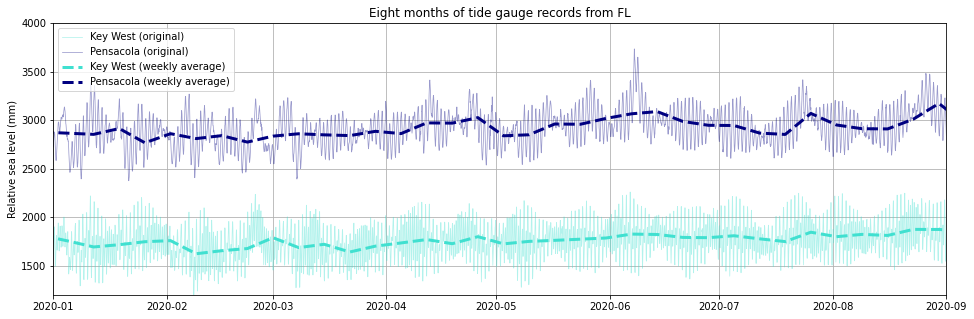

In [8]:
# 1a. Correlate the two Pandas Series, "key_west" and "pensacola", using the .corr() function.
# 1b. From this, calculate and print r^2.
# 1c. How much of the hourly variance in Key West sea level can be explained by sea level in Pensacola?
r = key_west.corr(pensacola)
print('The r^2 value is:',r**2)
print('This means that ~22% of the variance in one location can be explained by the other location\'s record.\n')

# 2. Calculate weekly averages of both time series using .resample().
#    Recall you can find the frequency offset codes here: https://pandas.pydata.org/docs/user_guide/timeseries.html#offset-aliases
#
#    Save these as two new variables. Display one of them to check that it worked.
key_west_weekly = key_west.resample('W').mean()
pensacola_weekly = pensacola.resample('W').mean()
display(key_west_weekly)

# 3. Repeat Question 1 using the weekly average variables.
r = key_west_weekly.corr(pensacola_weekly)
print('\nThe r^2 value is:',r**2)
print('This means that ~61% of the weekly-average variance in one location can be explained by the other location\'s record.')

# 4. Run this code to plot eight months of the original records.
plt.figure(figsize=(16,5))
plt.plot(key_west.index.values,key_west.values,lw=0.75,alpha=0.4,c='turquoise',label='Key West (original)')
plt.plot(pensacola.index.values,pensacola.values,lw=0.75,alpha=0.4,c='navy',label='Pensacola (original)')
plt.grid()
plt.ylabel('Relative sea level (mm)')
plt.title('Eight months of tide gauge records from FL')
plt.xlim([datetime(2020,1,1),datetime(2020,9,1)])
plt.ylim([1200,4000])

# 5. Write code to add dashed lines to the plot for each weekly average time series.
#    Use a thicker line (e.g. width of 3).
#    Set the label argument for the new lines, and add a legend.
plt.plot(key_west_weekly.index.values,key_west_weekly.values,lw=3,ls='--',c='turquoise',label='Key West (weekly average)')
plt.plot(pensacola_weekly.index.values,pensacola_weekly.values,lw=3,ls='--',c='navy',label='Pensacola (weekly average)')
plt.legend(loc='upper left');

# **Breakout rooms: group 3 — monthly running means using `.rolling()`**

First, assign roles:
> * **Timekeeper:** keep things moving
>
> * **Coder:** share your screen and write the code based on input from everyone else
>
> * **Reporter:** before the end of the session, remind the Coder to paste their code into this [Google Document](https://docs.google.com/document/d/1HkbODx5MycvYKL06bCDYFf6DMmbDBP19m4MNjke5paM/edit?usp=sharing)

If you need help, check out the Lesson #15 Colab notebook, [available here](https://colab.research.google.com/drive/1z6vYlfFZbidD7RBv4VwAzstBwQFZ6bAw?usp=sharing).

The r^2 value is: 0.22689327917643126
This means that ~22% of the variance in one location can be explained by the other location's record.



time
1913-01-19 06:00:00.000000            NaN
1913-01-19 07:00:00.028800            NaN
1913-01-19 07:59:59.971200            NaN
1913-01-19 09:00:00.000000            NaN
1913-01-19 10:00:00.028800            NaN
                                 ...     
2020-09-30 19:00:00.028800    1955.654167
2020-09-30 19:59:59.971200    1955.990278
2020-09-30 21:00:00.000000    1956.294444
2020-09-30 22:00:00.028800    1956.616667
2020-09-30 22:59:59.971200    1956.984722
Name: sea_level, Length: 944082, dtype: float64


The r^2 value is: 0.7020080599893211
This means that ~71% of the monthly running mean variance in one location can be explained by the other location's record.


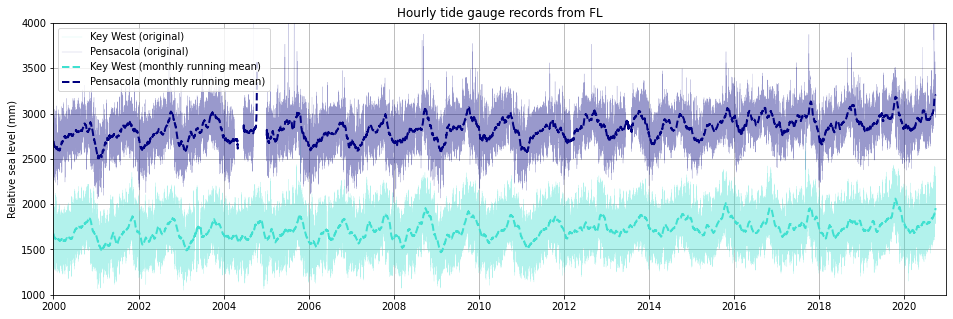

In [9]:
# 1a. Correlate the two Pandas Series, "key_west" and "pensacola", using the .corr() function.
# 1b. From this, calculate and print r^2.
# 1c. How much of the hourly variance in Key West sea level can be explained by sea level in Pensacola?
r = key_west.corr(pensacola)
print('The r^2 value is:',r**2)
print('This means that ~22% of the variance in one location can be explained by the other location\'s record.\n')

# 2. Calculate monthly running means of both hourly time series using .rolling().
#    Save these as two new variables. Display one of them to check that it worked.
key_west_monthly = key_west.rolling(window=24*30,min_periods=24).mean()
pensacola_monthly = pensacola.rolling(window=24*30,min_periods=24).mean()
display(key_west_monthly)

# 3. Repeat Question 1 using the monthly running mean variables.
r = key_west_monthly.corr(pensacola_monthly)
print('\nThe r^2 value is:',r**2)
print('This means that ~71% of the monthly running mean variance in one location can be explained by the other location\'s record.')

# 4. Run this code to plot the original records from 2000-2020.
plt.figure(figsize=(16,5))
plt.plot(key_west.index.values,key_west.values,lw=0.25,alpha=0.4,c='turquoise',label='Key West (original)')
plt.plot(pensacola.index.values,pensacola.values,lw=0.25,alpha=0.4,c='navy',label='Pensacola (original)')
plt.grid()
plt.ylabel('Relative sea level (mm)')
plt.title('Hourly tide gauge records from FL')
plt.xlim([datetime(2000,1,1),datetime(2020,12,31)])
plt.ylim([1000,4000])

# 5. Write code to add dashed lines to the plot for each monthly running mean time series.
#    Use a thicker line (e.g. width of 2).
#    Set the label argument for the new lines, and add a legend.
plt.plot(key_west_monthly.index.values,key_west_monthly.values,lw=2,ls='--',c='turquoise',label='Key West (monthly running mean)')
plt.plot(pensacola_monthly.index.values,pensacola_monthly.values,lw=2,ls='--',c='navy',label='Pensacola (monthly running mean)')
plt.legend(loc='upper left');

# **Breakout rooms: group 4 — annual running means using `.rolling()`**

First, assign roles:
> * **Timekeeper:** keep things moving
>
> * **Coder:** share your screen and write the code based on input from everyone else
>
> * **Reporter:** before the end of the session, remind the Coder to paste their code into this [Google Document](https://docs.google.com/document/d/1HkbODx5MycvYKL06bCDYFf6DMmbDBP19m4MNjke5paM/edit?usp=sharing)

If you need help, check out the Lesson #15 Colab notebook, [available here](https://colab.research.google.com/drive/1z6vYlfFZbidD7RBv4VwAzstBwQFZ6bAw?usp=sharing).

The r^2 value is: 0.22689327917643126
This means that ~22% of the variance in one location can be explained by the other location's record.



time
1913-01-19 06:00:00.000000            NaN
1913-01-19 07:00:00.028800            NaN
1913-01-19 07:59:59.971200            NaN
1913-01-19 09:00:00.000000            NaN
1913-01-19 10:00:00.028800            NaN
                                 ...     
2020-09-30 19:00:00.028800    1814.973973
2020-09-30 19:59:59.971200    1814.940183
2020-09-30 21:00:00.000000    1814.916438
2020-09-30 22:00:00.028800    1814.909932
2020-09-30 22:59:59.971200    1814.909703
Name: sea_level, Length: 944082, dtype: float64


The r^2 value is: 0.8657666951335451
This means that ~87% of the annual running mean variance in one location can be explained by the other location's record.


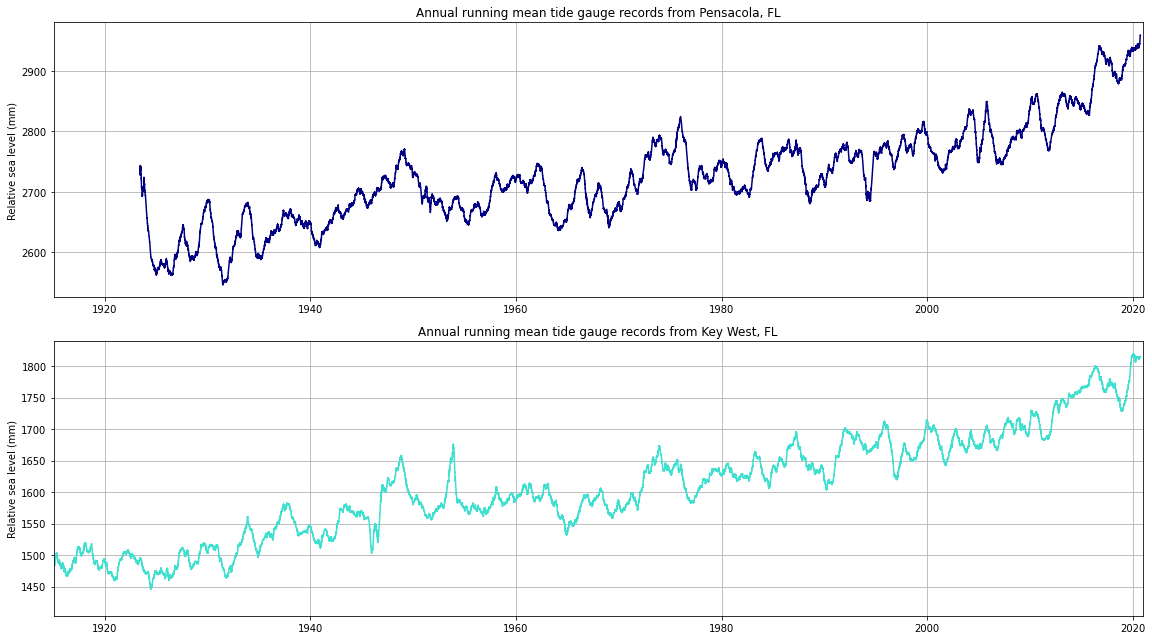

In [10]:
# 1a. Correlate the two Pandas Series, "key_west" and "pensacola", using the .corr() function.
# 1b. From this, calculate and print r^2.
# 1c. How much of the hourly variance in Key West sea level can be explained by sea level in Pensacola?
r = key_west.corr(pensacola)
print('The r^2 value is:',r**2)
print('This means that ~22% of the variance in one location can be explained by the other location\'s record.\n')

# 2. Calculate annual running means of both hourly time series using .rolling().
#    Save these as two new variables. Display one of them to check that it worked.
key_west_annual = key_west.rolling(window=24*365,min_periods=24*30).mean()
pensacola_annual = pensacola.rolling(window=24*365,min_periods=24*30).mean()
display(key_west_annual)

# 3. Repeat Question 1 using the annual running mean variables.
r = key_west_annual.corr(pensacola_annual)
print('\nThe r^2 value is:',r**2)
print('This means that ~87% of the annual running mean variance in one location can be explained by the other location\'s record.')

# 4. Run this code to set up two blank subplots.
fig, (ax0,ax1) = plt.subplots(ncols=1,nrows=2,figsize=(16,9))
ax0.grid()
ax0.set_ylabel('Relative sea level (mm)')
ax0.set_title('Annual running mean tide gauge records from Pensacola, FL')
ax0.set_xlim([datetime(1915,1,1),datetime(2020,12,31)])
ax1.grid()
ax1.set_ylabel('Relative sea level (mm)')
ax1.set_title('Annual running mean tide gauge records from Key West, FL')
ax1.set_xlim([datetime(1915,1,1),datetime(2020,12,31)])
plt.tight_layout()

# 5. Write code to add a line for each annual running mean time series on each subplot.
ax0.plot(pensacola_annual.index.values,pensacola_annual.values,c='navy',label='Pensacola (annual running mean)')
ax1.plot(key_west_annual.index.values,key_west_annual.values,c='turquoise',label='Key West (annual running mean)')
# plt.legend(loc='upper left');

# **Interpolating scattered global tide gauge measurements onto a 2-D grid**
### Practice with SciPy 2-D interpolation

**Data description:** CSV file with a compilation of global tide gauge estimates of sea level rise, expressed as linear trends (mm/year or feet/century). These are relative sea level (RSL) changes, which include both sea level rise (from ice melt and thermal expansion) and local vertical land motion (from subsidence and isostatic rebound).

**Data source:** [NOAA Tides & Currents](https://tidesandcurrents.noaa.gov/sltrends/) / NOAA Center for Operational Oceanographic Products and Services

1. Uncomment the blocks of code with the installation lines (`!pip install`, etc.). Remember the shortcut to uncomment/comment multiple lines is `Command-/` on Macs or `Control-/` on Windows.

2. Then run this cell to install the packages, import libraries, and give Colab access to Google Drive.

3. When prompted, click the link to give Colab access to Google Drive, copy the code, and paste back into here.

In [11]:
# # This code installs the netCDF4 module
# # Run this code once per session, then comment it out
# !pip install netcdf4

# # This code allows Cartopy to work with Google Colab
# # Run this code once per session, then comment it out
# !grep '^deb ' /etc/apt/sources.list | \
#   sed 's/^deb /deb-src /g' | \
#   tee /etc/apt/sources.list.d/deb-src.list
# !apt-get -qq update
# !apt-get -qq build-dep python3-cartopy
# !pip uninstall -y shapely
# !pip install shapely --no-binary shapely
# !pip install cartopy

# Import NumPy, xarray, Matplotlib, Cartopy (and related imports)
import numpy as np
import pandas as pd
from scipy import interpolate, stats
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# Give Colab access to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


4. Next, update the filepath below. To find the correct filepath, you can click on the left sidebar (folder icon), navigate to the Class #15 data folder, click the "..." on the file, and select "Copy path."

5. Add back slashes (`\`) in front of quotation marks in the filepath, as necessary.

In [12]:
# Filepath for SLR data set
filepath = '/content/drive/MyDrive/OCEAN 215 - Autumn \'20/OCEAN 215 - Autumn \'20 - Course documents/Zoom class slides and notebooks/2020-11-24 - class #15 - data/GlobalLinearSeaLevelTrends.csv'

6. Run the code cells below to load, display, and describe the CSV file using `pandas`.

In [13]:
# Load CSV file using Pandas
data = pd.read_csv(filepath)

# Display CSV file
display(data)

,Station ID,Station Name,First Year,Last Year,Year Range,% Complete,MSL Trends (mm/yr),+/- 95% CI (mm/yr),MSL Trend (ft/century),+/- 95% CI (ft/century),Latitude,Longitude
0,010-001,"Reykjavik, Iceland",1956,2018,63,0.9814,2.35,0.40,0.77,0.13,64.1500,-21.9333
1,015-011,"Torshavn, Denmark",1957,2006,50,0.8378,1.80,0.40,0.59,0.13,62.0167,-6.7667
2,025-001,"Barentsburg, Norway",1948,2018,71,0.9397,-2.65,0.45,-0.87,0.15,78.0667,14.2500
3,025-021,"Ny-Alesund, Norway",1976,2018,43,0.8895,-4.69,0.68,-1.54,0.22,78.9285,11.9380
4,030-003,"Russkaya Gavan II, Russia",1953,1993,41,0.9753,-0.54,1.05,-0.18,0.34,76.2000,62.5833
...,...,...,...,...,...,...,...,...,...,...,...,...
360,970-141,"Churchill, Canada",1940,2018,79,0.8997,-9.21,0.49,-3.02,0.16,58.7667,-94.1833
361,970-162,"Alert, Canada",1969,2018,50,0.2906,-2.34,1.07,-0.77,0.35,82.4900,-62.3200
362,970-211,"Tuktoyaktuk, Canada",1961,2018,58,0.4336,2.75,1.07,0.90,0.35,69.4167,-132.9667
363,999-001,"Bahia Esperanza, Antarctica",1961,1993,33,0.3528,-4.82,2.45,-1.58,0.80,-63.3000,-56.9167


In [16]:
# Describe CSV file
display(data.describe())

# We learn that:
# - There are 365 tide gauge stations in the data set
# - On average, the trends have been calculated based on 69.8 years of data
# - On average, the tide gauge records are about 87% complete
# - On average, the sea level rise trend is 0.46 feet per century (note that average rate in past 2 decades is twice that)
# - Longitudes span about -180 to 180°E; latitudes span 65°S to 82°N

,First Year,Last Year,Year Range,% Complete,MSL Trends (mm/yr),+/- 95% CI (mm/yr),MSL Trend (ft/century),+/- 95% CI (ft/century),Latitude,Longitude
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,1942.945205,2013.268493,69.802740,0.874792,1.401123,0.692356,0.459836,0.226849,25.952370,23.535294
std,34.157719,9.238847,35.107676,0.144909,2.445547,0.603309,0.802217,0.198167,32.793653,82.813661
min,1807.000000,1969.000000,10.000000,0.290600,-9.210000,0.080000,-3.020000,0.030000,-65.250000,-173.233300
25%,1927.000000,2014.000000,46.000000,0.816800,0.670000,0.340000,0.220000,0.110000,6.980500,-8.666700
50%,1954.000000,2018.000000,58.000000,0.934500,1.540000,0.510000,0.510000,0.170000,37.083300,15.550000
75%,1968.000000,2018.000000,85.000000,0.981100,2.430000,0.870000,0.800000,0.290000,51.500000,100.613300
max,1993.000000,2018.000000,212.000000,1.002700,16.870000,3.980000,5.530000,1.310000,82.490000,179.195200


7. Set up a world map using `Cartopy`, then plot the individual tide gauge measurements.

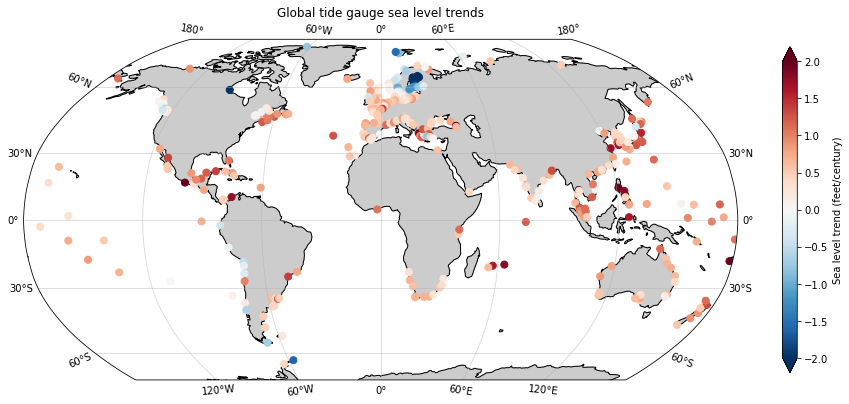

In [18]:
# Convert Pandas columns to 1-D NumPy arrays with data
lon_orig = data['Longitude'].values
lat_orig = data['Latitude'].values
msl_orig = data['MSL Trend (ft/century)'].values

# Set up world map
fig = plt.figure(figsize=(16,12))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(resolution='110m',linewidth=1)
gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,alpha=0.5)
ax.add_feature(cfeature.LAND,color='0.8')
ax.set_title('Global tide gauge sea level trends')

# Plot individual tide gauge trends
scat = plt.scatter(lon_orig,lat_orig,c=msl_orig,s=50,cmap='RdBu_r',vmin=-2,vmax=2,
                   transform=ccrs.PlateCarree(),zorder=2)
cbar = plt.colorbar(scat,ax=ax,extend='both',shrink=0.5)
cbar.set_label('Sea level trend (feet/century)')

8. Interpolate the 1-D array of lats, lons, and sea level measurements to a regularly-spaced 2-D grid of the world:

* Longitudes (x-values): -180° to 180°E (use 360 + 1 = 361 grid points)
* Latitudes (y-values): -90 to 90°N (use 180 + 1 = 181 grid points)

In [21]:
# Set up regularly-spaced x- and y- coordinates
lon_coord = np.linspace(-180,180,361)
lat_coord = np.linspace(-90,90,181)
# print(lon_coord)
# print(lat_coord)

# Mesh 1-D coordinates into a 2-D grid
lon_grid, lat_grid = np.meshgrid(lon_coord,lat_coord)
# print(lon_grid)
# print(lat_grid)

# Bilinearly interpolate 1-D data arrays to 2-D grid points
msl_gridded = interpolate.griddata((lon_orig,lat_orig),msl_orig,
                                   (lon_grid, lat_grid),
                                   method='linear')  # also try 'nearest'

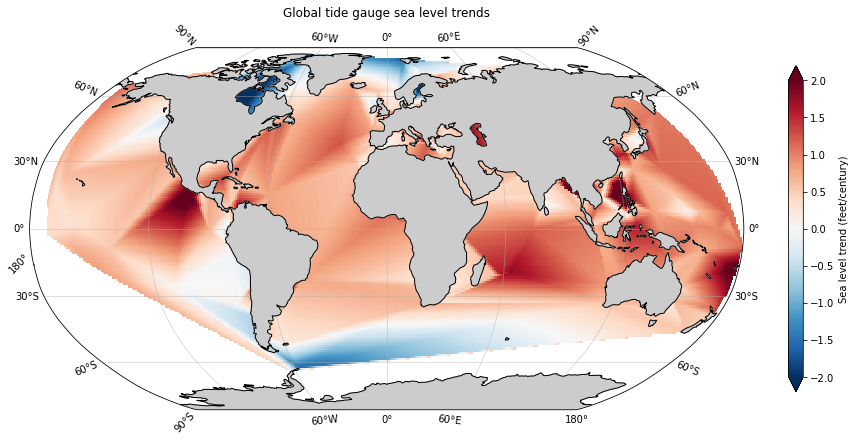

In [22]:
# Set up world map
fig = plt.figure(figsize=(16,12))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(resolution='110m',linewidth=1,zorder=3)
gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,alpha=0.5)
ax.add_feature(cfeature.LAND,color='0.8',zorder=2)
ax.set_title('Global tide gauge sea level trends')

# Plot interpolated tide gauge trends
pcm = plt.pcolormesh(lon_grid,lat_grid,msl_gridded,cmap='RdBu_r',vmin=-2,vmax=2,
                     transform=ccrs.PlateCarree(),zorder=1)
cbar = plt.colorbar(pcm,ax=ax,extend='both',shrink=0.5)
cbar.set_label('Sea level trend (feet/century)')

# **Regridding Arctic sea ice satellite measurements**
### Practice with SciPy 2-D interpolation

<img src="https://drive.google.com/uc?export=view&id=11vb4ytv85x40xAHn-f1TxHeMugma-141" width="400" />

*Image: Northern Hemisphere polar stereographic grid for sea ice concentrations. Source: [NSIDC](https://nsidc.org/data/NSIDC-0077/versions/2/print/).*

1. Uncomment the blocks of code with the installation lines (`!pip install`, etc.). Remember the shortcut to uncomment/comment multiple lines is `Command-/` on Macs or `Control-/` on Windows.

2. Then run this cell to install the packages, import libraries, and give Colab access to Google Drive.

3. When prompted, click the link to give Colab access to Google Drive, copy the code, and paste back into here.

In [ ]:
# # This code installs the netCDF4 module
# # Run this code once per session, then comment it out
# !pip install netcdf4

# # This code allows Cartopy to work with Google Colab
# # Run this code once per session, then comment it out
# !grep '^deb ' /etc/apt/sources.list | \
#   sed 's/^deb /deb-src /g' | \
#   tee /etc/apt/sources.list.d/deb-src.list
# !apt-get -qq update
# !apt-get -qq build-dep python3-cartopy
# !pip uninstall -y shapely
# !pip install shapely --no-binary shapely
# !pip install cartopy

# Import NumPy, xarray, Matplotlib, Cartopy (and related imports)
import numpy as np
import pandas as pd
from scipy import interpolate, stats
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# Give Colab access to Google Drive
from google.colab import drive
drive.mount('/content/drive')

4. Next, update the filepath below. To find the correct filepath, you can click on the left sidebar (folder icon), navigate to the Class #15 data folder, click the "..." on the file, and select "Copy path."

5. Add back slashes (`\`) in front of quotation marks in the filepath, as necessary.

In [ ]:
# Filepath for Arctic sea ice concentration netCDF file
filepath = '/content/drive/MyDrive/OCEAN 215 - Autumn \'20/OCEAN 215 - Autumn \'20 - Course documents/Zoom class slides and notebooks/2020-11-24 - class #15 - data/nsidc_sea_ice_cdr_north_original_grid.nc'

6. Run the code cell to load and display the netCDF file using `xarray`.

7. Notice that there are three dimensions: **lat** (50-90°N), **lon** (-180°E to 180°E), and **time** (1978 to 2020). The data are monthly in **time**.

In [ ]:
# Load netCDF file using xarray
data = xr.open_dataset(filepath)

# Display netCDF file
display(data)

<xarray.Dataset>
Dimensions:       (time: 503, xgrid: 304, ygrid: 448)
Coordinates:
  * time          (time) datetime64[ns] 1978-11-01 1978-12-01 ... 2020-10-01
  * ygrid         (ygrid) float32 5837500.0 5812500.0 ... -5312500.0 -5337500.0
  * xgrid         (xgrid) float32 -3837500.0 -3812500.0 ... 3712500.0 3737500.0
    latitude      (ygrid, xgrid) float64 ...
    longitude     (ygrid, xgrid) float64 ...
Data variables:
    sea_ice_conc  (time, ygrid, xgrid) float32 ...

8. Interpolate sea ice concentration on 2020-10-01 from the original grid of latitudes and longitudes to a grid of the following region:

* Longitudes (x-values): -180° to 180°E (use 360 * 2 = 720 grid points)
* Latitudes (y-values): 50° to 90°N (use 40 * 4 = 160 grid points)

In [ ]:
# Select SIC on 2020-10-01 on original grid
original = data['sea_ice_conc'].sel(time=datetime(2020,10,1)).squeeze()

# Mask out land values (coded as 2.54)
original.values[original.values > 2] = np.NaN

# Convert irregularly gridded lons, lats, and SIC data to flattened (1-D) NumPy arrays
lon_flat = original['longitude'].values.flatten()
lat_flat = original['latitude'].values.flatten()
sic_flat = original.values.flatten()
# print(lon_flat)
# print(lat_flat)
# print(sic_flat)

# Set up regularly-spaced x- and y- coordinates
lon_coord = np.linspace(-180,180,720)
lat_coord = np.linspace(50,90,160)
# print(lon_coord)
# print(lat_coord)

# Mesh 1-D coordinates into a 2-D grid
lon_grid, lat_grid = np.meshgrid(lon_coord,lat_coord)
# print(lon_grid)
# print(lat_grid)

# Bilinearly interpolate flattened data to 2-D grid points
sic_gridded = interpolate.griddata((lon_flat,lat_flat),sic_flat,
                                   (lon_grid, lat_grid),
                                   method='linear')

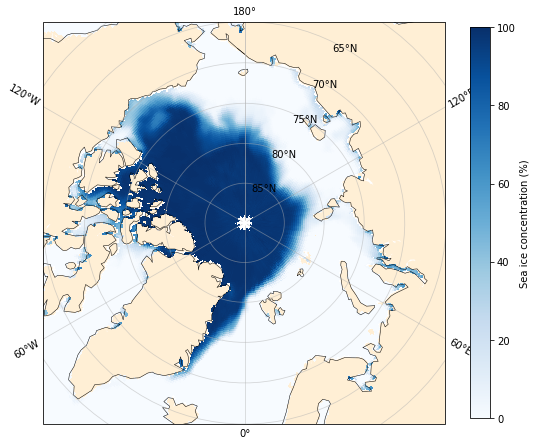

In [ ]:
# Make plot
fig = plt.figure(figsize=(9,9))
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=0))
ax.set_extent([-180, 180, 65, 90], crs=ccrs.PlateCarree())

# Option 1: pcolormesh() works for regridded data
pcm = ax.pcolormesh(lon_grid,lat_grid,100*sic_gridded,
                    transform=ccrs.PlateCarree(),cmap='Blues')
# # Option 2: contourf() works for regridded data
# pcm = ax.contourf(lon_grid,lat_grid,100*sic_gridded,
#                   transform=ccrs.PlateCarree(),cmap='Blues')
# # Option 3: pcolormesh() works for the original irregular data (CORRECTION TO VIDEO LESSON #14: sometimes this actually works)
# pcm = ax.pcolormesh(original['longitude'].values,original['latitude'].values,100*original.values,
#                     transform=ccrs.PlateCarree(),cmap='Blues')
# # Option 4: contourf() DOES NOT WORK for the original irregular data
# pcm = ax.contourf(original['longitude'].values,original['latitude'].values,100*original.values,
#                   transform=ccrs.PlateCarree(),cmap='Blues')

cbar = plt.colorbar(pcm,ax=ax,shrink=0.8)
cbar.set_label('Sea ice concentration (%)')

cs = ax.coastlines(resolution='110m',linewidth=0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,alpha=0.5)
ax.add_feature(cfeature.LAND, color='papayawhip')

# **Testing regular and irregular grids with `pcolormesh()` and `contourf()`**

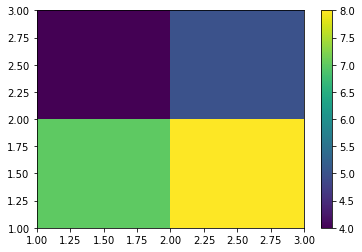

In [ ]:
plt.figure()
plt.pcolormesh(np.array([[1,2,3],[1,2,3],[1,2,3]]),
               np.array([[3,3,3],[2,2,2],[1,1,1]]),
               np.array([[4,5,6],[7,8,9],[10,11,12]]))
plt.colorbar()

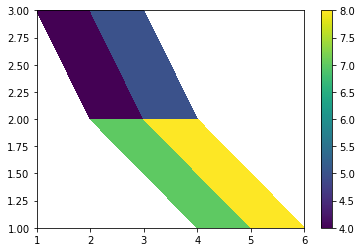

In [ ]:
plt.figure()
plt.pcolormesh(np.array([[1,2,3],[2,3,4],[4,5,6]]),
               np.array([[3,3,3],[2,2,2],[1,1,1]]),
               np.array([[4,5,6],[7,8,9],[10,11,12]]))
plt.colorbar()

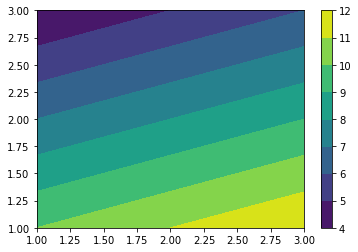

In [ ]:
plt.figure()
plt.contourf(np.array([[1,2,3],[1,2,3],[1,2,3]]),
               np.array([[3,3,3],[2,2,2],[1,1,1]]),
               np.array([[4,5,6],[7,8,9],[10,11,12]]))
plt.colorbar()

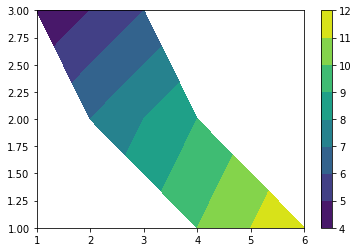

In [ ]:
plt.figure()
plt.contourf(np.array([[1,2,3],[2,3,4],[4,5,6]]),
               np.array([[3,3,3],[2,2,2],[1,1,1]]),
               np.array([[4,5,6],[7,8,9],[10,11,12]]))
plt.colorbar()